# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData=pd.read_csv('CowboyCigsData.csv',usecols=[1,2])

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [3]:
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [4]:
cigData.columns

Index(['Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [5]:
cigData.dtypes

Time         object
#CigSales     int64
dtype: object

In [6]:
#Do this transformation to make the exercises work
cigData['#CigSales']=(cigData['#CigSales']-1000000)*100000

Check whether there are any null values. 

In [7]:
na_df=pd.DataFrame(cigData.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount


## 2. Cleaning, transforming and visualizing

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [8]:
cigData.rename(columns={'Time':'Month'},inplace=True)

Call a head() to check this has worked. 

In [9]:
cigData.head()

,Month,#CigSales
0,1949-01,11200000
1,1949-02,11800000
2,1949-03,13200000
3,1949-04,12900000
4,1949-05,12100000


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [10]:
cigData.Month=pd.to_datetime(cigData.Month,format="%Y/%m")
cigData.set_index('Month',inplace=True)
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [11]:
y=cigData['#CigSales']

Check the type of our new variable. 

In [12]:
y.dtype

dtype('int64')

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [13]:
y.describe()

count    1.440000e+02
mean     2.802986e+07
std      1.199663e+07
min      1.040000e+07
25%      1.800000e+07
50%      2.655000e+07
75%      3.605000e+07
max      6.220000e+07
Name: #CigSales, dtype: float64

### 2f. Plotting `y`

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

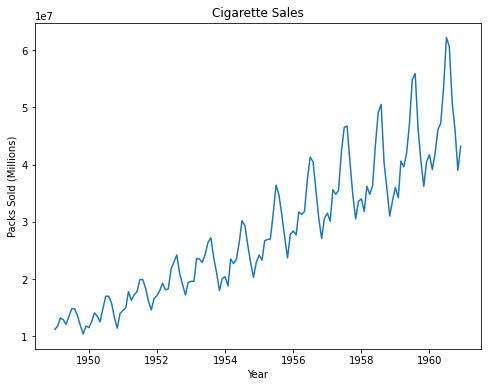

In [14]:
plt.subplots(figsize=(8,6))
plt.plot(y)
plt.title('Cigarette Sales')
plt.ylabel('Packs Sold (Millions)')
plt.xlabel('Year')
plt.show()

Observations: Yearly seasonality to the data. Trend upwards overtime. Hard to tell if seasonality has a bigger impact in the latter half of the graph, or its just due to the overall increase overtime, but the yearly swings get bigger. I hypothesize that cigarette sales are greater in the summer, when people are outside socializing more. 

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

Multiplicative.

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

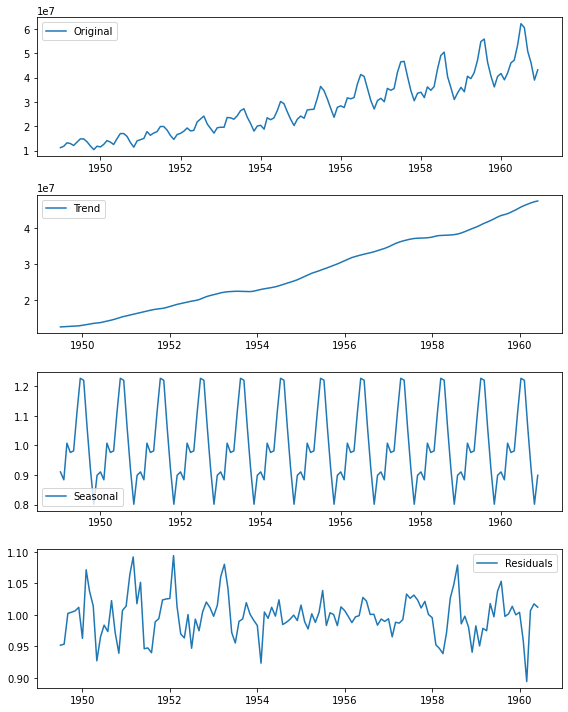

In [15]:
decomposition = sm.tsa.seasonal_decompose(y, model="multiplicative")
# Plot the original data, the trend, the seasonality, and the residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual= decomposition.resid.dropna()

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplots(figsize=(8,10))
plt.subplot(4,1,1)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(4,1,2)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(4,1,3)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(4,1,4)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [16]:
from statsmodels.tsa.stattools import kpss
kpss(y)

(1.052175011013511,
 0.01,
 14,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

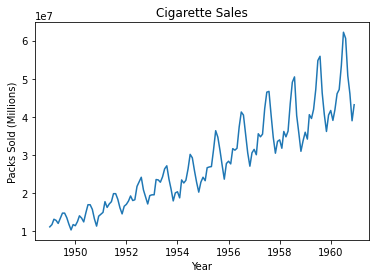

In [17]:
plt.plot(y)
plt.title('Cigarette Sales')
plt.ylabel('Packs Sold (Millions)')
plt.xlabel('Year')
plt.show()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One often  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [18]:
w=np.log(cigData)


When you plot this, you can see how the variance in our data now remains contant over time.

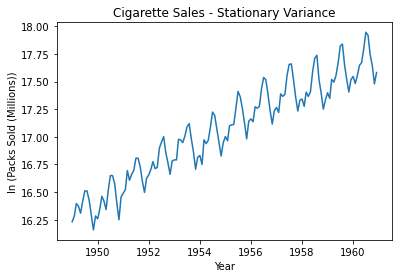

In [19]:
w=np.log(cigData)
plt.plot(w)
plt.title('Cigarette Sales - Stationary Variance')
plt.ylabel('ln (Packs Sold (Millions))')
plt.xlabel('Year')
plt.show()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

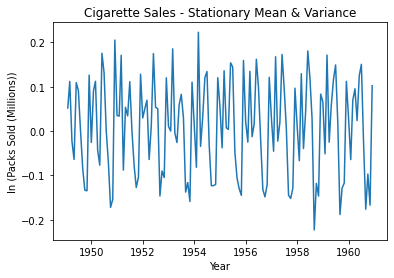

In [20]:
z=w.diff()
z.dropna(inplace=True)
plt.plot(z)
plt.title('Cigarette Sales - Stationary Mean & Variance')
plt.ylabel('ln (Packs Sold (Millions))')
plt.xlabel('Year')
plt.show()

In [21]:
print("Null hypothesis (p>0.05) of this test is that the time series data in question is stationary. \n")
kpss_stat, p_value, lags, crit= kpss(z)
print("kpss stat: {}".format(kpss_stat))
print("p_value: {}".format(p_value))

Null hypothesis (p>0.05) of this test is that the time series data in question is stationary. 

kpss stat: 0.10154458687402607
p_value: 0.1


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

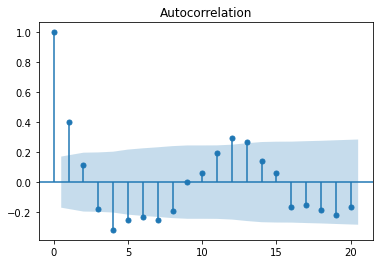

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
returns = np.random.normal(loc=0.02, scale=0.05, size=1000)
plot_acf(residual, lags=20)
plt.show()

In [23]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(z)
print('The p-value of the test on prices is: ' + str(results[1]))

The p-value of the test on prices is: 0.07112054815085686


### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [28]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [29]:
def evaluate_arima_model(data, arima_order):
    split=int(len(data) * 0.8) 
    test, train = data[0:split], data[split:len(data)]
    past=[x for x in train]
    predictions= list()
    for i in range(len(test)):
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    error = mean_squared_error(test, predictions)
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [30]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [31]:
#Determine best model parameters
p_values = [x for x in range(0, 3)]
d_values = [1]
q_values = [x for x in range(0, 3)]

evaluate_models(w.values, p_values, d_values, q_values)

ARIMA(0, 1, 0) MSE=0.027
ARIMA(0, 1, 1) MSE=0.029
ARIMA(0, 1, 2) MSE=0.030
ARIMA(1, 1, 0) MSE=0.028
ARIMA(1, 1, 1) MSE=0.031
ARIMA(2, 1, 0) MSE=0.034
ARIMA(2, 1, 1) MSE=0.036
ARIMA(2, 1, 2) MSE=0.035
Best ARIMA(0, 1, 0) MSE=0.027


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [32]:
p=0
d=1
q=0
model = ARIMA(w.values, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

We can take a look at a summary of the model this library has built around our data.

In [33]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  143
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 117.782
Method:                           css   S.D. of innovations              0.106
Date:                Fri, 28 May 2021   AIC                           -231.565
Time:                        13:59:38   BIC                           -225.639
Sample:                             1   HQIC                          -229.157
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.009      1.063      0.288      -0.008       0.027
==============================================================================
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

In [80]:
#Get Cummulative Sum 
pred_in_samp=model_fit.predict().cumsum()+w.iloc[0,0]
#Create time series with proper index, calculate exponential of the data to transform back to original state
pred_in_samp=np.exp(pd.Series(pred_in_samp,index=w.index[0:-1]))
#Create time index for out of sample prediction
pred_out_samp_index=pd.date_range(start=w.index[-1],periods=24,freq='M')
#Create data frame for out of sample prediction, calculate exponential
pred_out_samp=np.exp(pd.DataFrame(forecast[0],index=pred_out_samp_index,columns=['Forecast']))

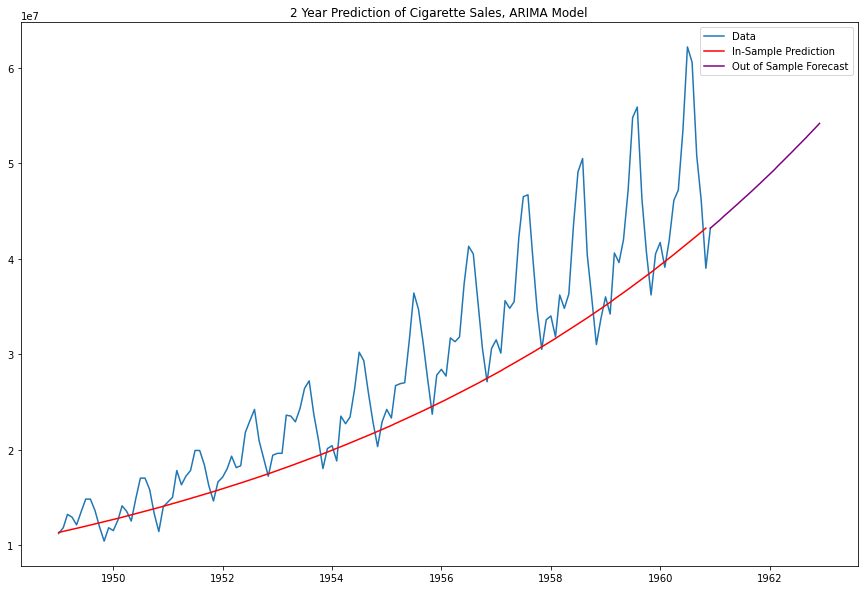

In [97]:
plt.subplots(figsize=(15,10))
#Plot Original Data
plt.plot(y,label='Data')
#Plot in-sample prediction
plt.plot(pred_in_samp, color = 'red',label='In-Sample Prediction')
#Get the last point from the data 
r=cigData.rename(columns={'#CigSales':'Forecast'}).iloc[[-1]]
#Add the last point from the data to the prediction plot for continuity 
plt.plot(pd.concat([r,pred_out_samp[['Forecast']]]),color='purple',label='Out of Sample Forecast')
plt.legend()
plt.title('2 Year Prediction of Cigarette Sales, ARIMA Model')
plt.show()

The model with the lowest MSE is not complex enough - it is only a linear regression, because it is of ARMA order (0,0). Perhaps accounting for seasonal changes with SARIMAX would be better suited. 

In [33]:
#Note: Could just use AIC/BIC Instead of MSE
def evaluate_sarimax_model(data, order, seasonal_order):
    split=int(len(data) * 0.8) 
    test, train = data[0:split], data[split:len(data)]
    past=[x for x in train]
    predictions= list()
    for i in range(len(test)):
        model = SARIMAX(past, order=order,seasonal_order=seasonal_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    error = mean_squared_error(test, predictions)
    return error

In [34]:
def evaluate_models_sarimax(dataset, p_values, d_values, q_values, p2, d2, q2, s):
    best_score, best_cfg1, best_cfg2 = float("inf"), None, None
    mse={}
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for p_ in p2:
                        for d_ in d2:
                            for q_ in q2:
                                order = (p,d,q)
                                order2= (p_,d_,q_,s)
                                try:
                                    mse = evaluate_sarimax_model(dataset, order, order2)
                                    if mse < best_score:
                                        best_score, best_cfg1, best_cfg2 = mse, order, order2
                                    print('Order%s Seasonal_Order%s MSE=%.3f' % (order,order2,mse))
                                except:
                                    continue
    return print('Best Order%s Seasonal_Order%s MSE=%.3f' % (best_cfg1, best_cfg2, best_score))

In [36]:
#Determine best model parameters
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 2)]
q_values = [x for x in range(0, 2)]

d=[1]
s=12

evaluate_models_sarimax(w.values, p_values, d, q_values, p_values, d_values, q_values, s=12)

Order(0, 1, 0) Seasonal_Order(0, 0, 0, 12) MSE=0.027
Order(0, 1, 0) Seasonal_Order(0, 0, 1, 12) MSE=0.025
Order(0, 1, 0) Seasonal_Order(0, 1, 0, 12) MSE=0.034
Order(0, 1, 0) Seasonal_Order(0, 1, 1, 12) MSE=0.039
Order(0, 1, 0) Seasonal_Order(1, 0, 0, 12) MSE=0.024
Order(0, 1, 0) Seasonal_Order(1, 0, 1, 12) MSE=0.022
Order(0, 1, 0) Seasonal_Order(1, 1, 0, 12) MSE=0.042
Order(0, 1, 0) Seasonal_Order(1, 1, 1, 12) MSE=0.040
Order(0, 1, 0) Seasonal_Order(2, 0, 0, 12) MSE=0.024
Order(0, 1, 0) Seasonal_Order(2, 0, 1, 12) MSE=0.023
Order(0, 1, 0) Seasonal_Order(2, 1, 0, 12) MSE=0.051
Order(0, 1, 0) Seasonal_Order(2, 1, 1, 12) MSE=0.055
Order(0, 1, 1) Seasonal_Order(0, 0, 0, 12) MSE=0.028
Order(0, 1, 1) Seasonal_Order(0, 0, 1, 12) MSE=0.025
Order(0, 1, 1) Seasonal_Order(0, 1, 0, 12) MSE=0.035
Order(0, 1, 1) Seasonal_Order(0, 1, 1, 12) MSE=0.039
Order(0, 1, 1) Seasonal_Order(1, 0, 0, 12) MSE=0.024
Order(0, 1, 1) Seasonal_Order(1, 0, 1, 12) MSE=0.022
Order(0, 1, 1) Seasonal_Order(1, 1, 0, 12) MSE

We can take a look at a summary of the model this library has built around our data.

In [98]:
#Create Model with Optimal Parameters
model2 = SARIMAX(w.values, order=(1,1,0),seasonal_order=(1,0,1,12))
model_fit2=model2.fit()
model_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 252.936
Date:                              Fri, 28 May 2021   AIC                           -497.871
Time:                                      14:18:26   BIC                           -486.020
Sample:                                           0   HQIC                          -493.055
                                              - 144                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3014      0.068     -4.424      0.000      -0.435      -0.168
ar.S.L12       0.9898      0.008    122.198      0.000       0.974       1.006
ma.S.L12      -0.5593      0.098     -5.698      0.000      -0.752      -0.367
sigma2         0.0014      0.000      8.724      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.75
Prob(Q):                              0.88   Prob(JB):                         0.69
Heteroskedasticity (H):               0.64   Skew:                             0.08
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

In [105]:
#Get In Sample Prediction
pred_in_samp2=model_fit2.predict()[1:]
#Get proper datetime index, calculate exponential
pred_in_samp2=np.exp(pd.Series(pred_in_samp2,index=w.index[1:]))
#Create datetime index for out of sample data
pred_out_samp_index=pd.date_range(start=w.index[-1],periods=24,freq='M')
#Get 2 month forecast for the data
df_res=model_fit2.get_forecast(steps=24).summary_frame()
#Set the index of the forecast 
df_res=df_res.set_index(pd.date_range(start='1960-12-31',periods=24,freq='M'))
#Calculate exponential of the data 
df_res=np.exp(df_res)

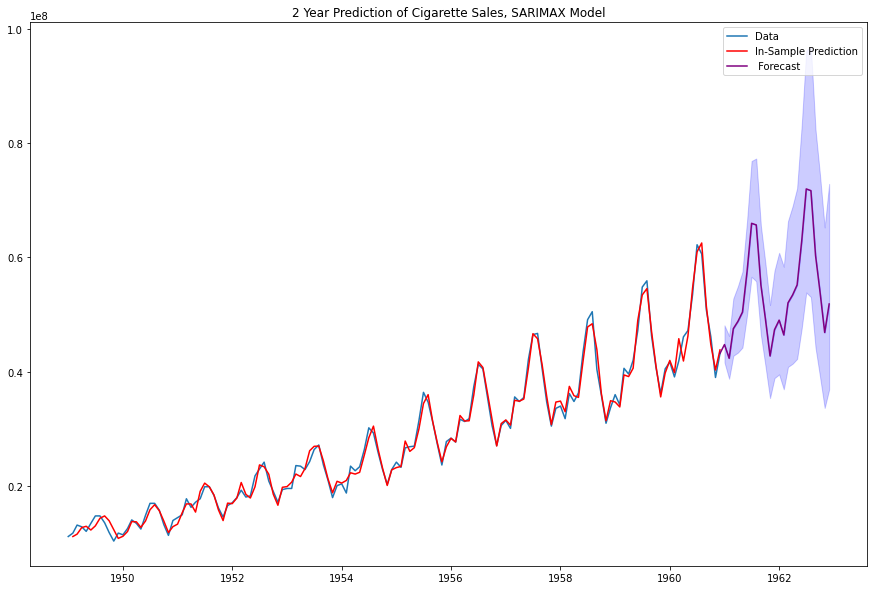

In [106]:
plt.subplots(figsize=(15,10))
#Plot Original Data
plt.plot(y,label='Data')
#Plot in-sample prediction
plt.plot(pred_in_samp2, color = 'red',label='In-Sample Prediction')
#Get the last point from the data 
r=cigData.rename(columns={'#CigSales':'mean'}).iloc[[-1]]
#Add the last point from the data to the prediction plot for continuity 
plt.plot(pd.concat([r,df_res[['mean']]]),color='purple',label=' Forecast')
#Plot confidence interval 
plt.fill_between(df_res.index,df_res['mean'], df_res['mean_ci_lower'],color='blue',alpha=0.2)
plt.fill_between(df_res.index,df_res['mean'], df_res['mean_ci_upper'],color='blue',alpha=0.2)
plt.legend()
plt.title('2 Year Prediction of Cigarette Sales, SARIMAX Model')
plt.show()

Just for fun, what happens if we try to predict 10 years ahead?

In [108]:
#Create datetime index for out of sample data
pred_out_samp_index=pd.date_range(start=w.index[-1],periods=24,freq='M')
#Get 2 month forecast for the data
df_res=model_fit2.get_forecast(steps=120).summary_frame()
#Set the index of the forecast 
df_res=df_res.set_index(pd.date_range(start='1960-12-31',periods=120,freq='M'))
#Calculate exponential of the data 
df_res=np.exp(df_res)

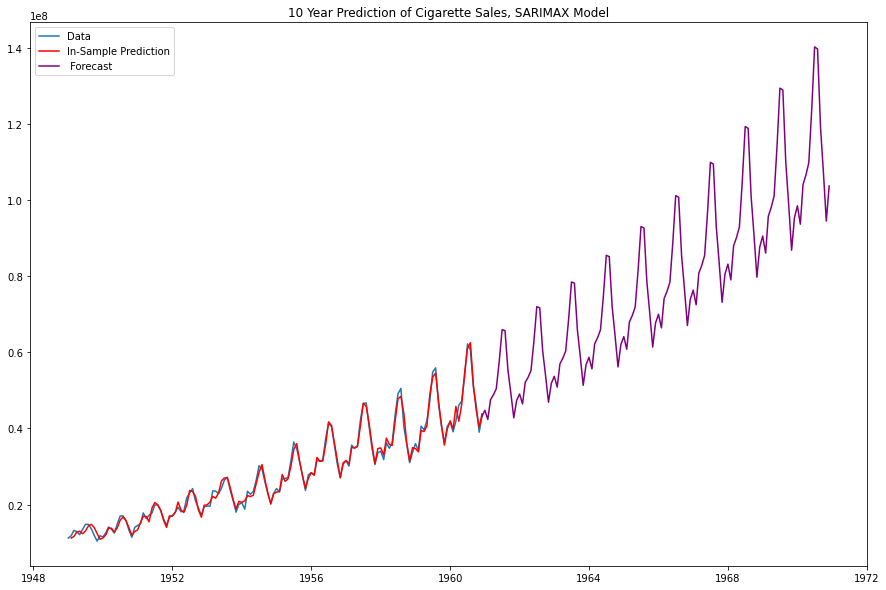

In [110]:
plt.subplots(figsize=(15,10))
#Plot Original Data
plt.plot(y,label='Data')
#Plot in-sample prediction
plt.plot(pred_in_samp2, color = 'red',label='In-Sample Prediction')
#Get the last point from the data 
r=cigData.rename(columns={'#CigSales':'mean'}).iloc[[-1]]
#Add the last point from the data to the prediction plot for continuity 
plt.plot(pd.concat([r,df_res[['mean']]]),color='purple',label=' Forecast')
#Plot confidence interval 
#plt.fill_between(df_res.index,df_res['mean'], df_res['mean_ci_lower'],color='blue',alpha=0.2)
#plt.fill_between(df_res.index,df_res['mean'], df_res['mean_ci_upper'],color='blue',alpha=0.2)
plt.legend()
plt.title('10 Year Prediction of Cigarette Sales, SARIMAX Model')
plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

This is done in the graphs above. 

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 